In [1]:
import json
from datasets import load_dataset

In [2]:
dataset = load_dataset("fka/awesome-chatgpt-prompts") # getting this off huggingface

split_ratio = 0.8
train_size = int(len(dataset['train']) * split_ratio) # test eval splir

train_data = dataset['train'].select(range(train_size))  #train data
eval_data = dataset['train'].select(range(train_size, len(dataset['train']))) # evaluation data  

def write_jsonl(data, filename):
    with open(filename, 'w') as f:
        for row in data:
            json_record = {"act": row["act"], "prompt": row["prompt"]} # making of jsonl for llms
            f.write(json.dumps(json_record) + '\n')

write_jsonl(train_data, 'train.jsonl')
write_jsonl(eval_data, 'eval.jsonl')

In [5]:
# nesecarry packages
!pip install -q -U bitsandbytes

In [6]:
!pip install -q -U git+https://github.com/huggingface/transformers.git

In [7]:
!pip install -q -U git+https://github.com/huggingface/peft.git

In [8]:
!pip install -q -U git+https://github.com/huggingface/accelerate.git

In [9]:
!pip install -q -U datasets scipy ipywidgets matplotlib einops

In [3]:

!pip install -q wandb -U

import wandb, os
wandb.login()

wandb_project = "journal-finetune"
if len(wandb_project) > 0:
    os.environ["WANDB_PROJECT"] = wandb_project



Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: minimalistnewsalerts (minimalistnewsalerts-sri-sri-university). Use `wandb login --relogin` to force relogin


In [4]:
from datasets import load_dataset

train_dataset = load_dataset('json', data_files='train.jsonl', split='train')
eval_dataset = load_dataset('json', data_files='eval.jsonl', split='train')

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [5]:
from transformers import AutoModelForCausalLM, AutoTokenizer

base_model_id = "microsoft/phi-2"
local_dir = "./microsoftphi2-better"

model = AutoModelForCausalLM.from_pretrained(base_model_id, cache_dir=local_dir)
tokenizer = AutoTokenizer.from_pretrained(base_model_id, cache_dir=local_dir)
tokenizer.pad_token = tokenizer.eos_token

def generate_and_tokenize_prompt(prompt):
    return tokenizer(formatting_func(prompt))

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
def formatting_func(example):
    text = f"### Act: {example['act']}\n### Prompt: {example['prompt']}"
    return text


In [7]:
# Check the structure of the dataset before tokenization
print(train_dataset[0])  # Print a single row from the dataset

# Check the first batch to ensure it's structured as expected
print(train_dataset[:5])  # Print the first 5 rows as a batch


{'act': 'An Ethereum Developer', 'prompt': 'Imagine you are an experienced Ethereum developer tasked with creating a smart contract for a blockchain messenger. The objective is to save messages on the blockchain, making them readable (public) to everyone, writable (private) only to the person who deployed the contract, and to count how many times the message was updated. Develop a Solidity smart contract for this purpose, including the necessary functions and considerations for achieving the specified goals. Please provide the code and any relevant explanations to ensure a clear understanding of the implementation.'}
{'act': ['An Ethereum Developer', 'SEO Prompt', 'Linux Terminal', 'English Translator and Improver', '`position` Interviewer'], 'prompt': ['Imagine you are an experienced Ethereum developer tasked with creating a smart contract for a blockchain messenger. The objective is to save messages on the blockchain, making them readable (public) to everyone, writable (private) only

In [8]:
def generate_and_tokenize_prompt(examples):
    prompts = examples["prompt"]
    max_length =256
    formatted_prompts = [formatting_func({"act": "example_act", "prompt": prompt}) for prompt in prompts]
    # payload management
    result = tokenizer(
        formatted_prompts,
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    
    result["labels"] = result["input_ids"].copy()
    
    return result

In [9]:
# tokenization
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt, batched=True)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt, batched=True)

Map:   0%|          | 0/136 [00:00<?, ? examples/s]

Map:   0%|          | 0/34 [00:00<?, ? examples/s]

170


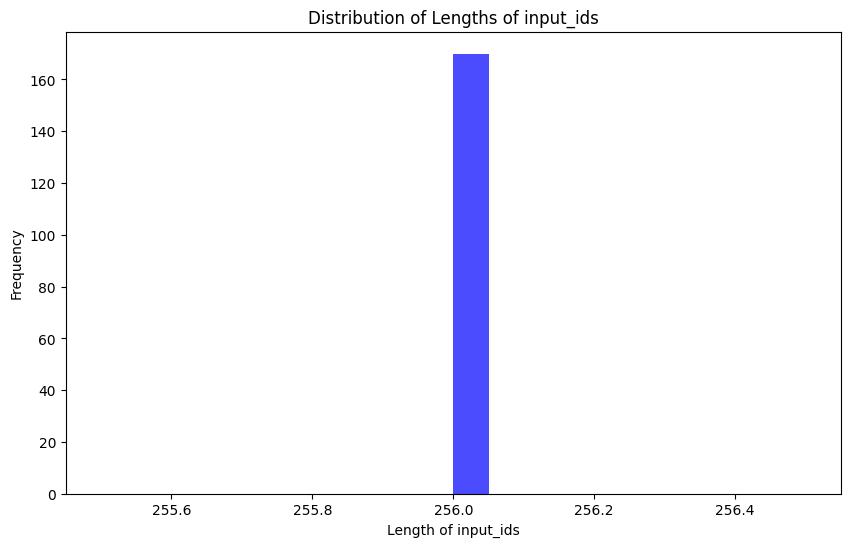

In [10]:
import matplotlib.pyplot as plt
def plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(len(lengths))
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset) # the length is fixed due to hardware constraints

In [11]:
print(tokenized_train_dataset[1]['input_ids'])

[21017, 2191, 25, 1672, 62, 529, 198, 21017, 45965, 25, 8554, 5313, 47, 23439, 11, 2251, 281, 19001, 329, 281, 2708, 326, 481, 307, 362, 11, 830, 2456, 319, 262, 21179, 705, 13014, 30850, 36454, 6, 1912, 319, 262, 1353, 838, 2482, 422, 3012, 13, 40348, 790, 5981, 9087, 1744, 13, 9175, 262, 21179, 12109, 286, 262, 1182, 654, 1029, 13, 1114, 1123, 2665, 286, 262, 19001, 11, 2291, 262, 1573, 954, 13, 40348, 18749, 82, 2665, 287, 262, 19001, 1165, 11, 1912, 319, 661, 635, 1265, 2665, 422, 3012, 329, 262, 21179, 13, 770, 19001, 1276, 307, 845, 6496, 290, 9815, 11, 523, 326, 314, 460, 2251, 257, 362, 11, 830, 1573, 2708, 422, 340, 13, 2980, 378, 257, 890, 1351, 286, 406, 11584, 290, 399, 19930, 26286, 3519, 284, 616, 21179, 13, 4418, 2291, 597, 584, 2456, 3519, 284, 262, 21179, 13, 13786, 502, 257, 1351, 286, 513, 5981, 7097, 6117, 284, 2291, 290, 262, 7151, 18021, 2420, 13, 6889, 1654, 484, 447, 247, 260, 407, 11780, 6685, 13, 27758, 262, 19001, 656, 636, 352, 290, 636, 362, 13, 50256, 5025

In [ ]:
import torch
eval_prompt  = "This is a short speech by a CEO of a fintech company of only 100 words"
eval_tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_bos_token=True,
    use_fast=False, 
)
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cpu")

model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(model.generate(**model_input, max_new_tokens=256, repetition_penalty=1.15)[0], skip_special_tokens=True))


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


In [ ]:
# LORA dimension analysis by returning the trainable params
def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )
print_trainable_parameters(model)  

In [ ]:
print(model)

In [ ]:
from peft import LoraConfig, get_peft_model
import torch
from accelerate import Accelerator

# Making this device and platform agnostic
print("CUDA Available: ", torch.cuda.is_available())
print("Using CPU")
accelerator = Accelerator()

config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=[
        "Wqkv",
        "fc1",
        "fc2",
    ],
    bias="none",
    lora_dropout=0.05,  
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
model = accelerator.prepare_model(model)
def print_trainable_parameters(model):
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total Trainable Parameters: {total_params}")

print_trainable_parameters(model)


In [ ]:
!pip install -q -U git+https://github.com/huggingface/accelerate.git

In [ ]:
import transformers
from datetime import datetime

project = "tensorgo-challenge"
base_model_name = "phi2"
run_name = f"{base_model_name}-{project}"
output_dir = f"./{run_name}"

train_dataset = tokenized_train_dataset.select(range(1))  
eval_dataset = tokenized_val_dataset.select(range(1))    

trainer = transformers.Trainer(
    model=model,
    train_dataset=train_dataset,  
    eval_dataset=eval_dataset,   
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        per_device_train_batch_size=1, 
        gradient_accumulation_steps=1,  
        max_steps=1,  
        learning_rate=2e-5,  
        logging_steps=10000, 
        save_strategy="no", 
        eval_strategy="no", 
        do_eval=False,  
        report_to=None, 
        use_cpu=True,  
        run_name=None,  
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False

trainer.train()


In [ ]:
# final test bench
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

base_model_id = "microsoft/phi-2"
base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,  # Phi2, same as before
    device_map="auto",
    trust_remote_code=True,
    load_in_8bit=True,
    torch_dtype=torch.float16,
)

eval_tokenizer = AutoTokenizer.from_pretrained(base_model_id, add_bos_token=True, trust_remote_code=True, use_fast=False)
eval_tokenizer.pad_token = tokenizer.eos_token